**NOTE** Currently this notebook runs with MlpMixer on GPUs and TPUs, but Vision
Transformers only run on GPUs. This is due to a temporary regression in the TPU
Node setup that is used for Colab and will be fixed soon.

See code at https://github.com/google-research/vision_transformer/

See papers at

- Vision Transformer: https://arxiv.org/abs/2010.11929
- MLP-Mixer: https://arxiv.org/abs/2105.01601

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

##### Copyright 2021 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [2]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'no'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/vision_transformer_colab'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

In [3]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Cloning into 'vision_transformer'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 1), reused 17 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.
Already up to date.


In [5]:
!pip install -qr vision_transformer/vit_jax/requirements.txt

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 81kB 2.8MB/s 
     |████████████████████████████████| 184kB 9.8MB/s 
     |████████████████████████████████| 92kB 5.5MB/s 
     |████████████████████████████████| 168.3MB 45kB/s 


### Imports

In [6]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [7]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'Mixer-B_16'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://mixer_models/imagenet21k/Mixer-B_16.npz...
- [1 files][289.6 MiB/289.6 MiB]                                                
Operation completed over 1 objects/289.6 MiB.                                    


In [8]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

Connected to TPU.


In [9]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [10]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/momentum_clip.py')
files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

In [12]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [13]:
dataset = 'cifar10'
batch_size = 512

In [14]:
pp_config = common_config.DATASET_PRESETS[dataset]['pp']
if model_name.startswith('Mixer'):
  # Mixer tokens are fixed.
  pp_config['crop'] = 224
  pp_config['resize'] = 256
pp_config

crop: 224
resize: 256
test: test
train: train[:98%]

In [15]:
# Note the datasets are configured in input_pipeline.DATASET_PRESETS
# Have a look in the editor at the right.
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
# tf.data.Datset for training, infinite repeats.
ds_train = input_pipeline.get_data(
    dataset=dataset, mode='train', repeats=None, batch_size=batch_size,
    pp_config=pp_config,
)
# tf.data.Datset for evaluation, single repeat.
ds_test = input_pipeline.get_data(
    dataset=dataset, mode='test', repeats=1, batch_size=batch_size,
    pp_config=pp_config,
)

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmpdjnimu5ltfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmplnqo8ayutfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmph_tu4mldtfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)


INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /root/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.c8d9420a53e043e78091c27134764ffa...
INFO:absl:Generating split train


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete9TKVA0/cifar10-train.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/cifar10/3.0.2.incomplete9TKVA0/cifar10-train.tfrecord. Shard lengths: [50000]
INFO:absl:Generating split test


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete9TKVA0/cifar10-test.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/cifar10/3.0.2.incomplete9TKVA0/cifar10-test.tfrecord. Shard lengths: [10000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split train[:98%], from /root/tensorflow_datasets/cifar10/3.0.2


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/cifar10/3.0.2


In [16]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(8, 64, 224, 224, 3)

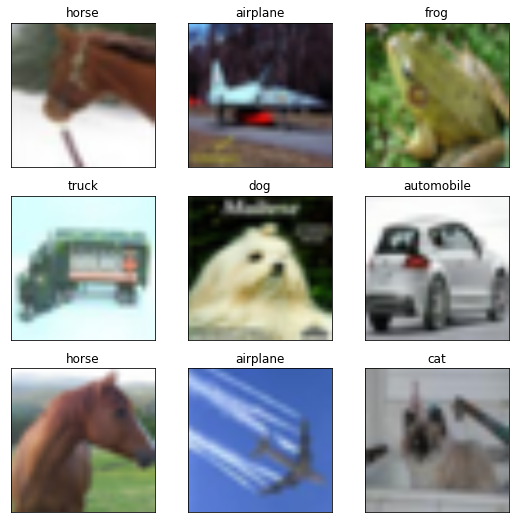

In [17]:
# Show some imags with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

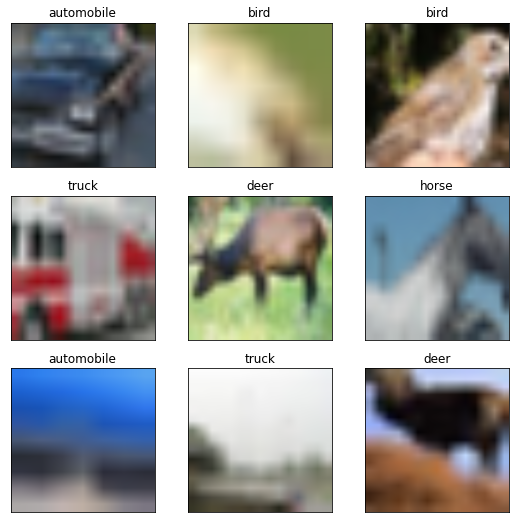

In [18]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [19]:
config = common_config.get_config()
config.model = models_config.MODEL_CONFIGS[model_name]
config

accum_steps: 8
base_lr: 0.03
batch: 512
batch_eval: 512
checkpoint_every: 1000
dataset: ''
decay_type: cosine
eval_every: 100
grad_norm_clip: 1.0
mixup_alpha: 0.0
model:
  channels_mlp_dim: 3072
  hidden_dim: 768
  name: Mixer-B_16
  num_blocks: 12
  patches:
    size: !!python/tuple
    - 16
    - 16
  tokens_mlp_dim: 384
optim_dtype: bfloat16
prefetch: 2
pretrained_dir: .
progress_every: 10
shuffle_buffer: 50000
tfds_data_dir: null
tfds_manual_dir: null
total_steps: null
trainer: train
warmup_steps: 500

In [20]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('ViT'):
  model = models.VisionTransformer(num_classes=num_classes, **config.model)
elif model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **config.model)
else:
  raise ValueError(f'Unknown model class: "{model_name}"')
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [21]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=config.model,
)

### Evaluate

In [22]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:317: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:304: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


params.cls: DeviceArray (10,)
params_repl.cls: ShardedDeviceArray (8, 10)


In [23]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [24]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [25]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [01:06<00:00,  3.52s/it]


DeviceArray(0.10063734, dtype=float32)

### Fine-tune

In [26]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [27]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:317: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:304: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


In [28]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:317: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:304: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:317: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:304: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "
100%|██████████| 100/100 [06:56<00:00,  4.17s/it]


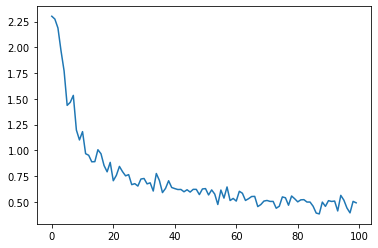

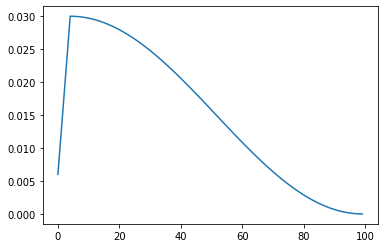

In [29]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [30]:
# Should be ~96.7% for Mixer-B/16 on CIFAR10
get_accuracy(opt_repl.target)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:56<00:00,  2.96s/it]


DeviceArray(0.9672081, dtype=float32)

### Inference

In [31]:
# Download a pre-trained model.

if model_name.startswith('ViT'):
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **config.model)
elif model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **config.model)
else:
  raise ValueError(f'Unknown model class: "{model_name}"')

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

Copying gs://mixer_models/imagenet1k/Mixer-B_16.npz...
/ [1 files][228.5 MiB/228.5 MiB]                                                
Operation completed over 1 objects/228.5 MiB.                                    


In [32]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [33]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2021-06-15 07:28:54--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.132.128, 74.125.201.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2021-06-15 07:28:55 (75.5 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



--2021-06-15 07:28:55--  https://picsum.photos/224
Resolving picsum.photos (picsum.photos)... 104.26.4.30, 172.67.74.163, 104.26.5.30, ...
Connecting to picsum.photos (picsum.photos)|104.26.4.30|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://i.picsum.photos/id/1003/224/224.jpg?hmac=Q-kJfoEh8tsWfW17FeHhMN9w5AfcHwnl--9iYHvkoP0 [following]
--2021-06-15 07:28:55--  https://i.picsum.photos/id/1003/224/224.jpg?hmac=Q-kJfoEh8tsWfW17FeHhMN9w5AfcHwnl--9iYHvkoP0
Resolving i.picsum.photos (i.picsum.photos)... 104.26.4.30, 172.67.74.163, 104.26.5.30, ...
Connecting to i.picsum.photos (i.picsum.photos)|104.26.4.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg              [ <=>                ]   7.20K  --.-KB/s    in 0s      

2021-06-15 07:28:56 (43.0 MB/s) - ‘picsum.jpg’ saved [7368]



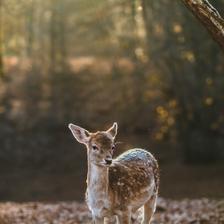

In [34]:
# Get a random picture with the correct dimensions.
resolution = pp_config['crop']
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

In [35]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [36]:
preds = flax.nn.softmax(logits)
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.63521 : Ibizan_hound, Ibizan_Podenco
0.06852 : hog, pig, grunter, squealer, Sus_scrofa
0.05729 : red_wolf, maned_wolf, Canis_rufus, Canis_niger
0.05037 : dingo, warrigal, warragal, Canis_dingo
0.02521 : grey_fox, gray_fox, Urocyon_cinereoargenteus
0.01677 : wallaby, brush_kangaroo
0.01125 : German_short-haired_pointer
0.01033 : Chihuahua
0.00837 : kit_fox, Vulpes_macrotis
0.00579 : coyote, prairie_wolf, brush_wolf, Canis_latrans
